In [1]:
!pip install pillow tqdm


In [2]:
import shutil

src = "/kaggle/input/arcade-dataset/arcade_challenge_datasets"
dst = "/kaggle/working/ARCADE"

shutil.copytree(src, dst, dirs_exist_ok=True)
print("✅ Dataset copié vers :", dst)


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '/kaggle/input/arcade-dataset/arcade_challenge_datasets'

In [ ]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm

# === CONFIGURATION ===
COCO_JSON = "/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/annotations/instances_default.json"  # Votre fichier d'annotations
IMAGE_DIR = "/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/images"         # Dossier contenant les images
OUTPUT_DIR = "/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/label3" # Dossier de sortie
os.makedirs(OUTPUT_DIR, exist_ok=True)

# CHARGEMENT ET MAPPING DES CATÉGORIES
with open(COCO_JSON) as f:
    data = json.load(f)

# Création automatique du mapping des catégories
category_mapping = {}
for idx, cat in enumerate(data['categories']):
    category_mapping[cat['id'] ]= idx + 1  # 0 réservé pour le background

print("Mapping des catégories:")
for orig_id, new_id in category_mapping.items():
    print(f"COCO category_id {orig_id} -> Masque valeur {new_id}")

#  FONCTION DE GÉNÉRATION
def generate_mask(img_info, annotations):
    h, w = img_info['height'], img_info['width']
    mask = np.zeros((h, w), dtype=np.uint8)

    for ann in annotations:
        cat_id = ann['category_id']
        if cat_id not in category_mapping:
            print(f"Attention: category_id {cat_id} non trouvé, ignoré")
            continue

        # Conversion des coordonnées
        seg = ann['segmentation']
        if isinstance(seg, list):
            for polygon in seg:
                pts = np.array(polygon, np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(mask, [pts], category_mapping[cat_id])

    return mask

# PROCESSUS PRINCIPAL
for img in tqdm(data['images'], desc="Génération des masques"):
    img_anns = [a for a in data['annotations'] if a['image_id'] == img['id']]

    if not img_anns:
        print(f"Attention: Aucune annotation pour {img['file_name']}")
        continue

    mask = generate_mask(img, img_anns)
    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{img['file_name'].rsplit('.', 1)[0]}.png"), mask)

print("✅ Génération terminée!")

Mapping des catégories:
COCO category_id 1 -> Masque valeur 1
COCO category_id 2 -> Masque valeur 2
COCO category_id 3 -> Masque valeur 3
COCO category_id 4 -> Masque valeur 4
COCO category_id 5 -> Masque valeur 5
COCO category_id 6 -> Masque valeur 6
COCO category_id 7 -> Masque valeur 7
COCO category_id 8 -> Masque valeur 8
COCO category_id 9 -> Masque valeur 9
COCO category_id 10 -> Masque valeur 10
COCO category_id 11 -> Masque valeur 11
COCO category_id 12 -> Masque valeur 12
COCO category_id 13 -> Masque valeur 13
COCO category_id 14 -> Masque valeur 14
COCO category_id 15 -> Masque valeur 15
COCO category_id 16 -> Masque valeur 16
COCO category_id 17 -> Masque valeur 17
COCO category_id 18 -> Masque valeur 18
COCO category_id 19 -> Masque valeur 19
COCO category_id 20 -> Masque valeur 20
COCO category_id 21 -> Masque valeur 21
COCO category_id 22 -> Masque valeur 22
COCO category_id 23 -> Masque valeur 23
COCO category_id 24 -> Masque valeur 24
COCO category_id 25 -> Masque vale

Génération des masques: 100%|██████████| 300/300 [00:00<00:00, 798.23it/s]

✅ Génération terminée!


In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

base_dir = "/kaggle/working/ARCADE/arcade_challenge_datasets"
train_img_dir = os.path.join(base_dir, "dataset_phase_1/segmentation_dataset/seg_train/images")
train_mask_dir = os.path.join(base_dir, "dataset_phase_1/segmentation_dataset/seg_train/label3")
val_img_dir = os.path.join(base_dir, "dataset_phase_1/segmentation_dataset/seg_val/images")
val_mask_dir = os.path.join(base_dir, "dataset_phase_1/segmentation_dataset/seg_val/label3")
test_img_dir = os.path.join(base_dir, "dataset_final_phase/test_case_segmentation/images")
test_mask_dir = os.path.join(base_dir, "dataset_final_phase/test_case_segmentation/label")


output_dir = os.path.join(base_dir, "dataset_final_phase/combined_dataset")
os.makedirs(os.path.join(output_dir, "train/images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "train/masks"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test/images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test/masks"), exist_ok=True)

# 1. Lister tous les fichiers disponibles
def get_valid_files(img_dir, mask_dir):
    valid_files = []
    for f in os.listdir(img_dir):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            mask_path = os.path.join(mask_dir, f)
            if os.path.exists(mask_path):
                valid_files.append(f)
            else:
                print(f"Avertissement: Masque manquant pour {f} - ignoré")
    return valid_files

train_images = get_valid_files(train_img_dir, train_mask_dir)
val_images = get_valid_files(val_img_dir, val_mask_dir)  #
test_images = get_valid_files(test_img_dir, test_mask_dir)

# 2. Combiner et mélanger
all_files = train_images + val_images + test_images
random.shuffle(all_files)  # Mélange aléatoire

# 3. Séparation train/test (80/20)
split_idx = int(0.7 * len(all_files))
train_files = all_files[:split_idx]
test_files = all_files[split_idx:]

# 4. Copie des fichiers avec gestion des erreurs
def safe_copy(src, dst):
    try:
        shutil.copy(src, dst)
    except FileNotFoundError:
        print(f"Erreur: Fichier non trouvé - {src}")
        return False
    return True

def copy_files(files, output_img_dir, output_mask_dir):
    for file in files:
        # Chercher le fichier dans les différents répertoires
        src_img = None
        src_mask = None

        # Chercher dans train d'abord
        if os.path.exists(os.path.join(train_img_dir, file)):
            src_img = os.path.join(train_img_dir, file)
            src_mask = os.path.join(train_mask_dir, file)
        # Puis dans val
        elif os.path.exists(os.path.join(val_img_dir, file)):
            src_img = os.path.join(val_img_dir, file)
            src_mask = os.path.join(val_mask_dir, file)
        # Puis dans test
        elif os.path.exists(os.path.join(test_img_dir, file)):
            src_img = os.path.join(test_img_dir, file)
            src_mask = os.path.join(test_mask_dir, file)

        if src_img and src_mask:
            dst_img = os.path.join(output_img_dir, file)
            dst_mask = os.path.join(output_mask_dir, file)

            if not (safe_copy(src_img, dst_img) and safe_copy(src_mask, dst_mask)):
                print(f"Échec de copie pour la paire {file}")
        else:
            print(f"Fichier {file} non trouvé dans aucun des répertoires sources")

# Copie des fichiers
copy_files(train_files,
          os.path.join(output_dir, "train/images"),
          os.path.join(output_dir, "train/masks"))

copy_files(test_files,
          os.path.join(output_dir, "test/images"),
          os.path.join(output_dir, "test/masks"))

print("Opération terminée avec succès!")
print(f"Nombre total d'images: {len(all_files)}")
print(f"Train: {len(train_files)} images")
print(f"Test: {len(test_files)} images")

Avertissement: Masque manquant pour 38.png - ignoré
Avertissement: Masque manquant pour 56.png - ignoré
Avertissement: Masque manquant pour 180.png - ignoré
Avertissement: Masque manquant pour 222.png - ignoré
Avertissement: Masque manquant pour 35.png - ignoré
Avertissement: Masque manquant pour 294.png - ignoré
Avertissement: Masque manquant pour 89.png - ignoré
Avertissement: Masque manquant pour 258.png - ignoré
Avertissement: Masque manquant pour 207.png - ignoré
Avertissement: Masque manquant pour 14.png - ignoré
Avertissement: Masque manquant pour 139.png - ignoré
Avertissement: Masque manquant pour 191.png - ignoré
Avertissement: Masque manquant pour 202.png - ignoré
Avertissement: Masque manquant pour 9.png - ignoré
Avertissement: Masque manquant pour 138.png - ignoré
Avertissement: Masque manquant pour 16.png - ignoré
Avertissement: Masque manquant pour 248.png - ignoré
Avertissement: Masque manquant pour 74.png - ignoré
Avertissement: Masque manquant pour 65.png - ignoré
Ave

In [ ]:
from collections import Counter
import numpy as np
import os
import cv2
from tqdm import tqdm

def compute_class_pixel_distribution(mask_dir, num_classes=26):
    pixel_counts = Counter()

    mask_files = sorted(os.listdir(mask_dir))
    for mask_file in tqdm(mask_files):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            if u < num_classes:
                pixel_counts[u] += c

    for cls in range(num_classes):
        print(f"Classe {cls:02d} : {pixel_counts[cls]} pixels")
    return pixel_counts


train_mask_dir = "/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/combined_dataset/train/masks"
pixel_counts = compute_class_pixel_distribution(train_mask_dir)


100%|██████████| 983/983 [00:04<00:00, 236.48it/s]

Classe 00 : 249042072 pixels
Classe 01 : 668560 pixels
Classe 02 : 684274 pixels
Classe 03 : 673773 pixels
Classe 04 : 499019 pixels
Classe 05 : 594089 pixels
Classe 06 : 821153 pixels
Classe 07 : 678266 pixels
Classe 08 : 572401 pixels
Classe 09 : 478062 pixels
Classe 10 : 124445 pixels
Classe 11 : 23980 pixels
Classe 12 : 1119 pixels
Classe 13 : 508530 pixels
Classe 14 : 151037 pixels
Classe 15 : 342462 pixels
Classe 16 : 594872 pixels
Classe 17 : 249318 pixels
Classe 18 : 99181 pixels
Classe 19 : 70252 pixels
Classe 20 : 330591 pixels
Classe 21 : 52499 pixels
Classe 22 : 67121 pixels
Classe 23 : 38472 pixels
Classe 24 : 162850 pixels
Classe 25 : 159154 pixels


In [ ]:
test_mask_dir = "/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/combined_dataset/test/masks"
pixel_counts = compute_class_pixel_distribution(test_mask_dir)

100%|██████████| 710/710 [00:03<00:00, 232.36it/s]

Classe 00 : 179795803 pixels
Classe 01 : 505488 pixels
Classe 02 : 522642 pixels
Classe 03 : 502232 pixels
Classe 04 : 381014 pixels
Classe 05 : 420327 pixels
Classe 06 : 580699 pixels
Classe 07 : 491443 pixels
Classe 08 : 412142 pixels
Classe 09 : 336208 pixels
Classe 10 : 93808 pixels
Classe 11 : 22231 pixels
Classe 12 : 1119 pixels
Classe 13 : 363601 pixels
Classe 14 : 106806 pixels
Classe 15 : 255494 pixels
Classe 16 : 421842 pixels
Classe 17 : 186624 pixels
Classe 18 : 70521 pixels
Classe 19 : 53719 pixels
Classe 20 : 255605 pixels
Classe 21 : 41457 pixels
Classe 22 : 47989 pixels
Classe 23 : 28758 pixels
Classe 24 : 111628 pixels
Classe 25 : 113040 pixels


In [ ]:
!pip install iterative-stratification


In [ ]:
!pip install monai[all] albumentations opencv-python torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━

In [ ]:
threshold = 10000
rare_classes = [cls for cls, count in pixel_counts.items() if count < threshold]
print("📉 Classes sous-représentées :", rare_classes)


📉 Classes sous-représentées : [12]


In [ ]:
import random
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class ARCADESegmentationBalancedDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, oversample_classes=None, repeat_factor=5):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.oversample_classes = oversample_classes or []
        self.repeat_factor = repeat_factor

        self.image_list = sorted(os.listdir(image_dir))
        self.samples = self.build_balanced_list()

    def build_balanced_list(self):
        samples = []
        for img_name in self.image_list:
            mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                continue
            unique_classes = np.unique(mask)
            repeat = self.repeat_factor if any(cls in self.oversample_classes for cls in unique_classes) else 1
            samples.extend([img_name] * repeat)
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '.png'))

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_transform = A.Compose([
    # Resize avec interpolation
    A.Resize(224, 224, interpolation=cv2.INTER_LINEAR),

    # Rotations limitées
    A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT),

    # Légers ajustements de position
    A.ShiftScaleRotate(shift_limit=0.05,
                      scale_limit=0.1,
                      rotate_limit=10,
                      p=0.5,
                      border_mode=cv2.BORDER_CONSTANT),

    # Déformations élastiques subtiles
    A.ElasticTransform(alpha=0.5,
                      sigma=25,
                      alpha_affine=10,
                      p=0.3),


    A.RandomBrightnessContrast(brightness_limit=0.1,  # Faible variation
                             contrast_limit=0.1,
                             p=0.3),

    # Flips horizontaux s
    A.HorizontalFlip(p=0.5),


    A.Perspective(scale=(0.05, 0.1)),

    # Normalisation
    A.Normalize(mean=(0.5,) * 3, std=(0.5,) * 3),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

# Transformation pour la validation
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,) * 3, std=(0.5,) * 3),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_35/1731230821.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=0.5,


In [ ]:
from torch.utils.data import DataLoader

train_dataset = ARCADESegmentationBalancedDataset(
    image_dir="/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/combined_dataset/train/images",
    mask_dir="/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/combined_dataset/train/masks",
    transform=train_transform,
    oversample_classes=rare_classes,
    repeat_factor=10
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)


In [ ]:
test_dataset = ARCADESegmentationBalancedDataset(
    image_dir="/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/combined_dataset/test/images",
    mask_dir="/kaggle/working/ARCADE/arcade_challenge_datasets/dataset_final_phase/combined_dataset/test/masks",
    transform=test_transform,
    oversample_classes=rare_classes,
    repeat_factor=10
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)


In [ ]:
import torch
import torch.nn as nn
import timm

class TransUNet(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()
        self.encoder = timm.create_model("vit_base_patch16_224", pretrained=True, features_only=True, in_chans=3)
        self.conv1 = nn.Conv2d(768, 256, kernel_size=1)
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(256, 128, 3, padding=1), nn.ReLU())
        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(128, 64, 3, padding=1), nn.ReLU())
        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(64, 32, 3, padding=1), nn.ReLU())
        self.out_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.conv1(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.out_conv(x)
        return x


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransUNet(num_classes=26).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
writer = SummaryWriter(log_dir='./logs')

2025-07-07 09:16:37.443228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751879797.637066      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751879797.695253      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
!pip install torchmetrics


In [ ]:
# Historiques
train_f1_history = []
best_train_f1 = 0.0

# Boucle d'entraînement
num_epochs = 20
for epoch in range(num_epochs):
    # Entraînement
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_masks = []

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1).detach().cpu().numpy().flatten()
        targets = masks.detach().cpu().numpy().flatten()
        all_train_preds.extend(preds)
        all_train_masks.extend(targets)

    # Calcul F1 Train
    train_f1 = f1_score(all_train_masks, all_train_preds, average="macro", zero_division=0)
    train_f1_history.append(train_f1)

    # Sauvegarde du meilleur modèle
    if train_f1 > best_train_f1:
        best_train_f1 = train_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_f1': train_f1,
            'loss': train_loss/len(train_loader)
        }, 'best_model.pth')
        print(f"Nouveau meilleur modèle (Train F1: {train_f1:.4f})")

    # Logging
    writer.add_scalar('Loss/train', train_loss/len(train_loader), epoch)
    writer.add_scalar('F1/train', train_f1, epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | Train F1: {train_f1:.4f}")

writer.close()

Nouveau meilleur modèle (Train F1: 0.6817)
Epoch 1/20 | Train Loss: 0.0403 | Train F1: 0.6817
Nouveau meilleur modèle (Train F1: 0.6857)
Epoch 2/20 | Train Loss: 0.0402 | Train F1: 0.6857
Epoch 3/20 | Train Loss: 0.0403 | Train F1: 0.6800
Epoch 4/20 | Train Loss: 0.0401 | Train F1: 0.6826
Nouveau meilleur modèle (Train F1: 0.6884)
Epoch 5/20 | Train Loss: 0.0402 | Train F1: 0.6884
Epoch 6/20 | Train Loss: 0.0406 | Train F1: 0.6841
Epoch 7/20 | Train Loss: 0.0401 | Train F1: 0.6790
Epoch 8/20 | Train Loss: 0.0402 | Train F1: 0.6779
Epoch 9/20 | Train Loss: 0.0403 | Train F1: 0.6797
Epoch 10/20 | Train Loss: 0.0405 | Train F1: 0.6794
Epoch 11/20 | Train Loss: 0.0399 | Train F1: 0.6848
Epoch 12/20 | Train Loss: 0.0404 | Train F1: 0.6755
Epoch 13/20 | Train Loss: 0.0402 | Train F1: 0.6794
Epoch 14/20 | Train Loss: 0.0405 | Train F1: 0.6761
Epoch 15/20 | Train Loss: 0.0402 | Train F1: 0.6787
Epoch 16/20 | Train Loss: 0.0402 | Train F1: 0.6803
Epoch 17/20 | Train Loss: 0.0405 | Train F1: 0.6

In [ ]:
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F

def evaluate_f1_on_test(model, test_loader, num_classes=26, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            #  Redimensionne la sortie à la même taille que les masques
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(masks.view(-1).cpu().numpy())

    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    per_class_f1 = f1_score(all_labels, all_preds, average=None, labels=list(range(num_classes)), zero_division=0)

    print(f" F1-score global (macro) : {macro_f1:.4f}")
    for i, f1 in enumerate(per_class_f1):
        print(f" Classe {i:02d} : F1-score = {f1:.4f}")


In [ ]:
evaluate_f1_on_test(model,val_loader)

In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm



def load_best_model(model_class):
    model = model_class().to(device)

    # Create a list of all numpy globals we need to allow
    numpy_globals = [
        numpy.core.multiarray.scalar,
        numpy.dtype,
        numpy.ndarray,
        numpy.float32,
        numpy.float64,

    ]

    try:
        # First try with all safe globals
        with torch.serialization.safe_globals(numpy_globals):
            checkpoint = torch.load('/kaggle/working/best_model.pth', weights_only=True)
    except Exception as e:
        print(f"Safe loading failed with: {str(e)}")
        print("Falling back to weights_only=False - ONLY USE IF YOU TRUST THE FILE SOURCE")
        checkpoint = torch.load('/kaggle/working/best_model.pth', weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded (Train F1: {checkpoint['train_f1']:.4f})")
    return model

model = load_best_model(TransUNet)
model.eval()

# 2. Évaluation sur l'ensemble de test
all_test_preds = []
all_test_masks = []
test_images = []
test_loss = 0.0

with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Testing"):
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        outputs = nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

        loss = criterion(outputs, masks)
        test_loss += loss.item()

        preds = outputs.argmax(dim=1).cpu().numpy()
        masks = masks.cpu().numpy()

        # Stockage pour métriques globales
        all_test_preds.extend(preds.flatten())
        all_test_masks.extend(masks.flatten())

        # Stockage des exemples pour visualisation
        test_images.append({
            'image': imgs[0].cpu().numpy().transpose(1, 2, 0),
            'true_mask': masks[0],
            'pred_mask': preds[0]
        })

# 3. Calcul des métriques
test_f1 = f1_score(all_test_masks, all_test_preds, average="macro", zero_division=0)
test_loss /= len(test_loader)

print("\n📊 Résultats finaux sur le test:")
print(f"Test Loss: {test_loss:.4f} | Test F1-Score: {test_f1:.4f}\n")


target_names = [f'Class{i}' for i in range(26)]

print(classification_report(
    all_test_masks,
    all_test_preds,
    target_names=target_names,
    zero_division=0
))

Safe loading failed with: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: Can only build Tensor, Parameter, OrderedDict or types allowlisted via `add_safe_globals`, but got <class 'numpy.dtypes.Float64DType'>

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.
Falling back to weights_only=False - ONLY USE IF YOU TRUST THE FILE SOURCE
Best model loaded (Train F1: 0.6884)


Testing: 100%|██████████| 180/180 [00:16<00:00, 11.03it/s]



📊 Résultats finaux sur le test:
Test Loss: 0.0319 | Test F1-Score: 0.6951

              precision    recall  f1-score   support

      Class0       0.99      0.99      0.99  34845039
      Class1       0.89      0.87      0.88     96716
      Class2       0.87      0.83      0.85     99900
      Class3       0.80      0.92      0.86     96121
      Class4       0.79      0.73      0.76     72849
      Class5       0.84      0.84      0.84     81254
      Class6       0.84      0.83      0.84    113922
      Class7       0.80      0.87      0.83     97204
      Class8       0.72      0.83      0.77     82277
      Class9       0.74      0.67      0.71     70287
     Class10       0.66      0.62      0.64     20942
     Class11       0.64      0.24      0.35      4217
     Class12       0.51      0.41      0.46      2190
     Class13       0.86      0.86      0.86     69583
     Class14       0.81      0.57      0.67     20376
     Class15       0.72      0.76      0.74     48855
     

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_batch_predictions(model, dataset, device='cuda', num_images=10):
    model.eval()
    plt.figure(figsize=(15, num_images * 3))

    for i in range(num_images):
        image, true_mask = dataset[i]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

        image_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.cpu().numpy()

        # Affichage de la ligne
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(image_np)
        plt.title("🖼️ Image")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(true_mask_np, cmap='tab20')
        plt.title("✅ Ground Truth")
        plt.axis("off")

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred_mask, cmap='tab20')
        plt.title("🔮 Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_35/4209058.py:35: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4209058.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4209058.py:35: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


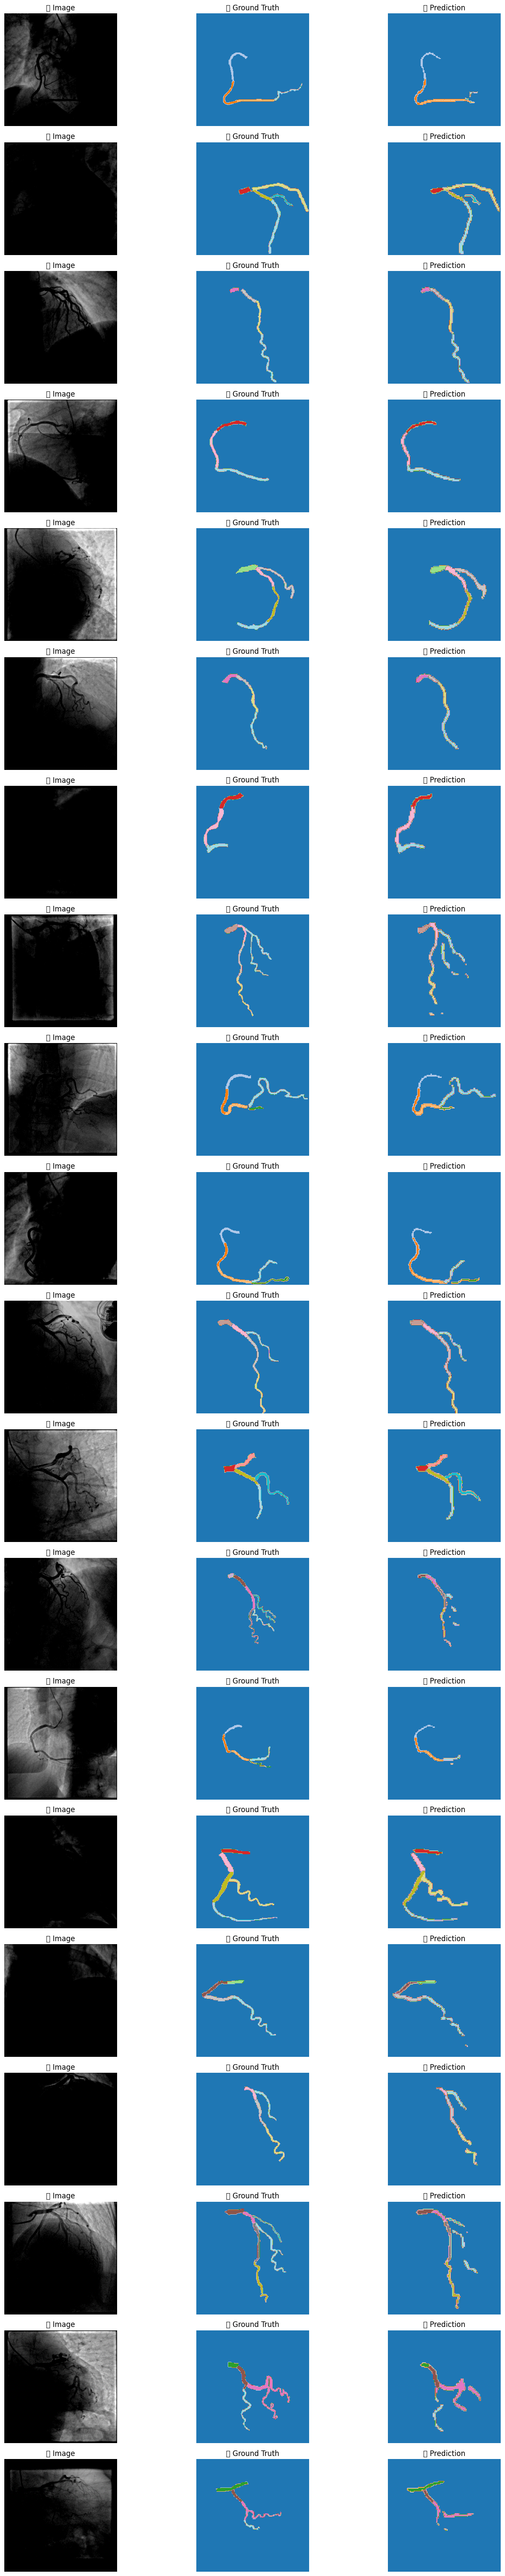

In [ ]:
visualize_batch_predictions(model, test_dataset, device=device, num_images=20)
